In [1]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [3]:
smifile = "250k_rndm_zinc_drugs_clean_3.csv"
data = pd.read_csv(smifile, delimiter = ",")
data = data.sample(n=10000, random_state=42)

In [4]:
data.head()

,smiles,logP,qed,SAS
100329,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...,1.13960,0.793487,3.843395
12103,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...,0.34360,0.784932,4.232355
170922,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n,4.85712,0.569373,3.463493
106167,C=CCc1ccccc1OC(C)=O\n,2.34040,0.401613,1.943724
33917,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...,4.10500,0.843003,2.639230


In [5]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("model_300dim.pkl")

In [9]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [13]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [14]:
data['mol'] = data['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [15]:
data['mol_sentence'] = data.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

In [22]:
mol2vec = [DfVec(x) for x in sentences2vec(data['mol_sentence'], model, unseen='UNK')]

In [24]:
mol2vec = np.array([x.vec for x in mol2vec])

In [45]:
mol2vec.shape

(10000, 300)

In [52]:
split= {f'vec_{i}': mol2vec[:, i] for i in range(mol2vec.shape[1])}

In [54]:
vecs = pd.DataFrame(split)

In [55]:
vecs.head()

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_290,vec_291,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,-0.595844,13.599172,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,1.148437,14.245388,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,0.347149,9.091203,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,-0.307675,6.528207,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,1.239658,12.163701,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615


In [94]:
vecs['logP'] = data['logP'].values
vecs['smiles'] = data['smiles'].values

In [95]:
vecs

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,logP,smiles
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712,1.13960,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018,0.34360,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865,4.85712,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917,2.34040,C=CCc1ccccc1OC(C)=O\n
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615,4.10500,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.149517,-5.912338,-3.342572,5.063833,1.209950,1.450080,-8.835844,-2.422362,3.261962,0.181602,...,8.066936,-5.068615,-5.878430,-4.655751,-5.748816,-2.033437,-10.135429,-1.273553,2.95734,Cc1cc(NC(=O)c2cc(C3CC3)nc3onc(C)c23)on1\n
9996,0.866559,-5.617601,-2.084500,1.500934,0.414463,-0.230240,-11.030504,-1.679072,6.781714,0.316821,...,7.834716,0.742749,-9.184113,-3.480695,-4.664177,-6.158488,-10.926046,-3.834805,2.14680,CCCCNC(=O)c1ccc(CNC(=O)N2CCO[C@H](C)C2)cc1\n
9997,1.767921,-5.417960,-2.414780,5.429947,-0.234058,-2.773077,-10.402782,-2.301766,6.844529,4.105608,...,6.886694,-1.467427,-7.947645,-4.368306,-7.309598,-5.828468,-11.302728,-1.049029,3.84539,COc1ccc(-c2n[nH]c(=S)n2CC(=O)NC2CCCCCCC2)cc1\n
9998,0.796060,-5.421035,-0.334348,4.779342,-1.001768,-1.208561,-8.081294,-1.126442,9.446869,2.685735,...,9.897014,-0.473376,-6.800110,-1.895076,-5.264774,-3.981951,-8.188497,-1.878498,2.83350,C[C@H]1C[C@H]1NC(=O)NC[C@@H](c1ccc(Cl)cc1)n1cc...


In [96]:
def generate_mol_vector(mol):
    mol_sentence = MolSentence(mol2alt_sentence(mol, 1))
    print(mol_sentence)
    mol2vec = DfVec(sentences2vec(mol_sentence, model, unseen='UNK'))
    return mol2vec.vec

In [97]:
smiles = Chem.MolFromSmiles("CCCNBr")

In [98]:
print('Molecular sentence:', mol2alt_sentence(smiles, radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(smiles, radius=1)))
print('\nDfVec object:',DfVec(sentences2vec(MolSentence(mol2alt_sentence(smiles, radius=1)), model, unseen='UNK')))

Molecular sentence: ['2246728737', '3542456614', '2245384272', '1173125914', '2245384272', '787069595', '847961216', '2278910100', '3612926680', '1113379627']

MolSentence object: MolSentence with 10 words

DfVec object: (10, 300) dimensional vector


In [99]:
vecs.head()

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,logP,smiles
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712,1.13960,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018,0.34360,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865,4.85712,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917,2.34040,C=CCc1ccccc1OC(C)=O\n
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615,4.10500,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...


In [157]:
# create random 2D data for clustering
from sklearn.datasets import make_blobs
dummy_data = make_blobs(n_samples=50, n_features=2, centers=5, cluster_std=1.5, random_state=42)

In [158]:
# create a dataframe with the data
df = pd.DataFrame(dummy_data[0], columns=['x', 'y'])

In [159]:
df.index = [f'point_{i}' for i in range(len(df))]

In [160]:
from sklearn.neighbors import NearestNeighbors
# create a nearest neighbor object
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(df)

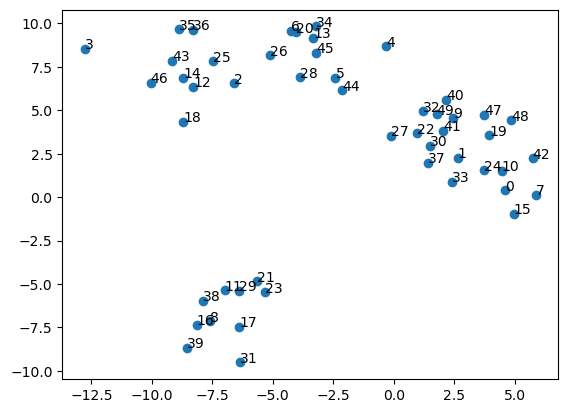

In [161]:
plt.plot(df['x'], df['y'], 'o')
for i in range(len(df)):
    plt.annotate(i, (df['x'][i], df['y'][i]))
plt.show()

In [162]:
point_14 = df.iloc[14]

In [163]:
nbrs_14 = nbrs.kneighbors([point_14])

/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [164]:
nbrs_14

(array([[0.        , 0.66270959, 1.08640794, 1.37730759, 1.55902814]]),
 array([[14, 12, 43, 46, 25]]))

In [165]:
df['neighpors'] = df.apply(lambda x: nbrs.kneighbors([x])[1][0], axis=1)

/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [166]:
df.head()

,x,y,neighpors
point_0,4.619633,0.386603,"[0, 10, 7, 15, 24]"
point_1,2.647600,2.268462,"[1, 37, 24, 30, 33]"
point_2,-6.621487,6.546118,"[2, 25, 12, 14, 26]"
point_3,-12.767945,8.556377,"[3, 46, 43, 35, 14]"
point_4,-0.310724,8.675622,"[4, 5, 45, 13, 34]"


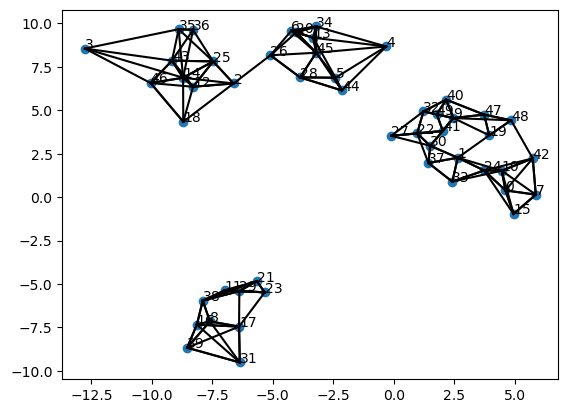

In [167]:
plt.plot(df['x'], df['y'], 'o')
for i in range(len(df)):
    plt.annotate(i, (df['x'][i], df['y'][i]))
    for j in df['neighpors'][i]:
        plt.plot([df['x'][i], df['x'][j]], [df['y'][i], df['y'][j]], 'k-')

In [169]:
# create graph of neighbors
import networkx as nx

In [170]:
G = nx.Graph()

In [171]:
G.add_nodes_from(df.index)

In [172]:
for i in range(len(df)):
    for j in df['neighpors'][i]:
        G.add_edge(df.index[i], df.index[j])

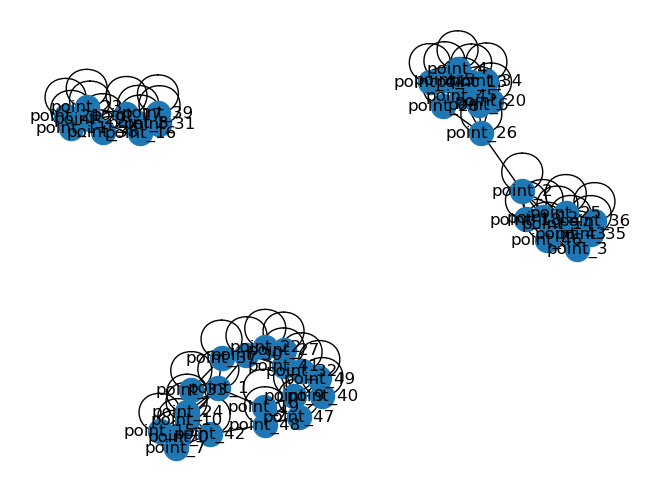

In [173]:
nx.draw(G, with_labels=True)

In [174]:
# is graph connected?
nx.is_connected(G)

False

In [189]:
def graph_from_df(df, neighbors=5, ignore_cols=False):
    # create a nearest neighbor object
    if ignore_cols:
        df = df.drop(ignore_cols, axis=1)
    nbrs = NearestNeighbors(n_neighbors=neighbors, algorithm='ball_tree').fit(df)
    # add neighbors to dataframe
    neighbors = df.apply(lambda x: nbrs.kneighbors([x])[1][0], axis=1)
    # create graph of neighbors
    G = nx.Graph()
    G.add_nodes_from(df.index)
    for i in range(len(df)):
        for j in neighbors[i]:
            G.add_edge(df.index[i], df.index[j])
    return G

In [190]:
df = pd.DataFrame(dummy_data[0], columns=['x', 'y'])

In [191]:
import warnings
warnings.filterwarnings('ignore')
for i in range(20):
    print(f'Graph with {i+1} neighbors is connected: {nx.is_connected(graph_from_df(df, neighbors=i+1))}')
    G = graph_from_df(df, neighbors=i+1)
    if nx.is_connected(G):
        break

Graph with 1 neighbors is connected: False
Graph with 2 neighbors is connected: False
Graph with 3 neighbors is connected: False
Graph with 4 neighbors is connected: False
Graph with 5 neighbors is connected: False
Graph with 6 neighbors is connected: False
Graph with 7 neighbors is connected: False
Graph with 8 neighbors is connected: False
Graph with 9 neighbors is connected: False
Graph with 10 neighbors is connected: False
Graph with 11 neighbors is connected: True


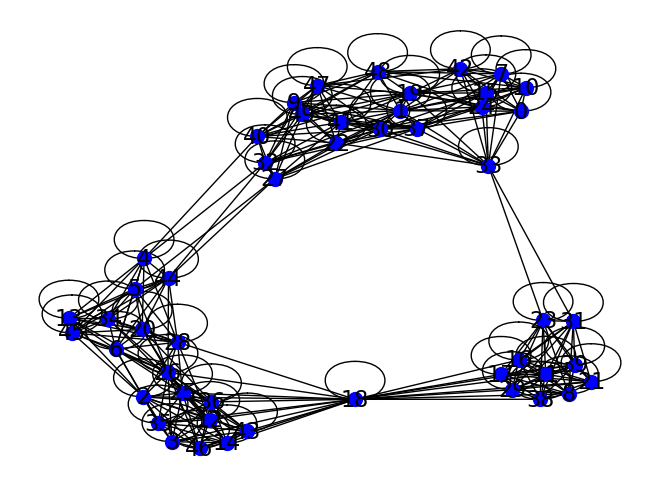

In [196]:
nx.draw(G, with_labels=True, node_color='b', node_size=100, font_size=16)

In [197]:
vecs.head()

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,logP,smiles
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712,1.13960,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018,0.34360,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865,4.85712,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917,2.34040,C=CCc1ccccc1OC(C)=O\n
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615,4.10500,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...


In [198]:
G = graph_from_df(vecs, neighbors=5, ignore_cols=['logP', 'smiles'])

In [202]:
nx.is_connected(G)

True

In [208]:
# add neighbors to dataframe
%time
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(vecs.drop(['logP', 'smiles'], axis=1))
test_vecs = vecs.drop(['logP', 'smiles'], axis=1)


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.01 µs


In [210]:
test_vecs['neighbors'] = test_vecs.apply(lambda x: nbrs.kneighbors([x])[1][0], axis=1)

In [211]:
test_vecs.head()

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_291,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,neighbors
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,13.599172,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712,"[0, 7592, 2508, 8608, 9714]"
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,14.245388,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018,"[1, 588, 6776, 71, 7093]"
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,9.091203,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865,"[2, 1786, 3148, 4270, 4640]"
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,6.528207,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917,"[3, 798, 7048, 1752, 4005]"
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,12.163701,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615,"[4, 1621, 1570, 2564, 8931]"


In [287]:
import random
random.seed(42)
target = vecs.logP.values
class GraphSearch:
    def __init__(self, idx, neighbors):
        self.idx = idx
        self.lr = 0.1
        self.neighbors = neighbors
        self.start_id = random.choice(idx)
        self.best_current_id = self.start_id
        self.best_current = self._fitness(self.start_id)
        self.best_global_id = self.start_id
        self.best_global = self._fitness(self.start_id)
        self.visited = set()
        print(f'Starting search from {self.start_id}')
        print(f'Neighbors: {self.neighbors[self.start_id]}')
        print(f'Fitness: {self._fitness(self.start_id)}')
    def _fitness(self, id):
        return target[id] - self.lr * len(self.neighbors[id])
    def _update_visited(self, id):
        self.visited.add(id)
    def _update_best_current(self, id):
        if self._fitness(id) > self.best_global:
            self.best_global = self._fitness(id)
            self.best_global_id = id
    def step(self, id):
        # get neighbors
        neighbors = self.neighbors[id][1:]
        # update visited
        self._update_visited(id)
        # get fitness of neighbors
        fitness = [self._fitness(x) for x in neighbors]
        visited = [x not in self.visited for x in neighbors]
        debug_dict = dict(zip(neighbors, fitness))
        debug_dict_2 = dict(zip(neighbors, visited))
        print(f'Neighbors: {debug_dict}')
        print(f'Visited: {debug_dict_2}')
        # get best non-visited neighbor
        best_neighbor = neighbors[np.argmax(np.array(fitness) * np.array(visited))]
        # update best current
        self._update_best_current(best_neighbor)
        if best_neighbor in self.visited:
            print(best_neighbor)
            print('No more neighbors to visit')
            return None
        else:
            return best_neighbor
    def search(self, n_steps):
        for n in range(n_steps):
            self.best_current_id = self.step(self.best_current_id)
            self.best_current = self._fitness(self.best_current_id)
            if self.best_current_id is None:
                break
            print(f'Best current id {self.best_current_id} with fitness {self._fitness(self.best_current_id)}')
            print(f'Best global id {self.best_global_id} with fitness {self._fitness(self.best_global_id)}')


In [288]:
test = GraphSearch(test_vecs.index, test_vecs.neighbors)

Starting search from 1824
Neighbors: [1824 1619 3085  485 7801]
Fitness: 3.6550000000000002


In [289]:
test.search(1000)

Neighbors: {1619: 3.1491, 3085: 1.4977, 485: 3.4723, 7801: 3.324}
Visited: {1619: True, 3085: True, 485: True, 7801: True}
Best current id 485 with fitness 3.4723
Best global id 1824 with fitness 3.6550000000000002
Neighbors: {1824: 3.6550000000000002, 5020: 3.02584, 3838: 3.2837, 1619: 3.1491}
Visited: {1824: False, 5020: True, 3838: True, 1619: True}
Best current id 3838 with fitness 3.2837
Best global id 1824 with fitness 3.6550000000000002
Neighbors: {485: 3.4723, 9040: 3.7636000000000003, 9909: 4.1283, 5841: 4.1283}
Visited: {485: False, 9040: True, 9909: True, 5841: True}
Best current id 9909 with fitness 4.1283
Best global id 9909 with fitness 4.1283
Neighbors: {9909: 4.1283, 9851: 4.4351, 5177: 3.363, 9040: 3.7636000000000003}
Visited: {9909: False, 9851: True, 5177: True, 9040: True}
Best current id 9851 with fitness 4.4351
Best global id 9851 with fitness 4.4351
Neighbors: {9909: 4.1283, 5841: 4.1283, 4103: 3.68232, 2501: 2.0521}
Visited: {9909: False, 5841: True, 4103: True,

KeyError: None

In [290]:
np.max(target)

7.9942199999999985

In [291]:
len(test.visited)

122

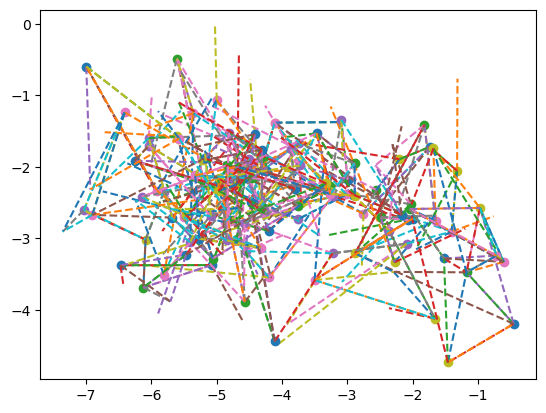

In [292]:
#dispay visited nodes
for i in test.visited:
    plt.plot(vecs.vec_1[i], vecs.vec_2[i], 'o')
    for j in test_vecs.neighbors[i]:
        plt.plot([vecs.vec_1[i], vecs.vec_1[j]], [vecs.vec_2[i], vecs.vec_2[j]], '--')


In [293]:
# import pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(vecs.drop(['logP', 'smiles'], axis=1))

PCA(n_components=2)

In [294]:
pca_vecs = pca.transform(vecs.drop(['logP', 'smiles'], axis=1))

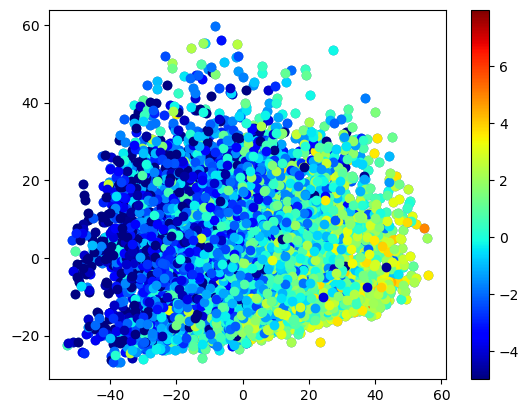

In [295]:
plt.plot(pca_vecs[:, 0], pca_vecs[:, 1], 'o')
# change color based on logP with jitter
colors = plt.cm.jet(target / np.max(target))
for i in range(len(pca_vecs)):
    plt.plot(pca_vecs[i, 0], pca_vecs[i, 1], 'o', color=colors[i])
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=np.min(target), vmax=np.max(target)))
sm._A = []
plt.colorbar(sm)

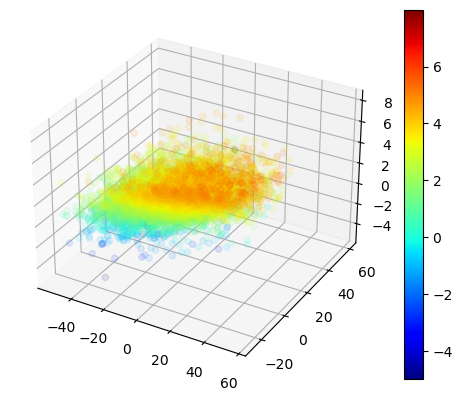

In [306]:
# 3d plot with logP as 3rd dimension
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_vecs[:, 0], pca_vecs[:, 1], target, c=target, cmap=plt.cm.jet, marker='o', alpha = 0.1)
# add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=np.min(target), vmax=np.max(target)))
sm._A = []
plt.colorbar(sm)

In [333]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [334]:
X_train, X_test, y_train, y_test = train_test_split(pca_vecs, vecs.logP.values, test_size=0.33, random_state=42)

In [335]:
reg = RandomForestRegressor().fit(X_train, y_train)

In [336]:
y_pred = reg.predict(X_test)

In [337]:
mean_squared_error(y_test, y_pred)

1.5502791689466566

In [339]:
def get_logP(X, model):
    return model.predict(X)

KeyboardInterrupt: 

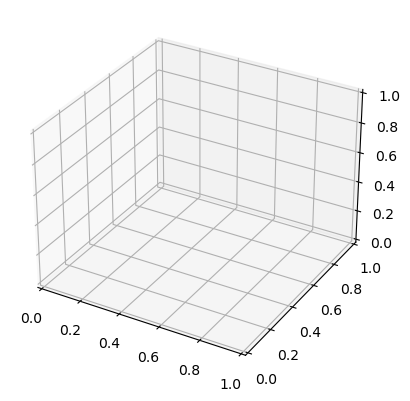

In [342]:
# plot 3d surface in style of gradient descent
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = pca_vecs[:, 0]
Y = pca_vecs[:, 1]
X,Y = np.meshgrid(X, Y)
# z - 3d hiperbolic paraboloid
Z = np.array([get_logP(np.array([x, y]).reshape(1, -1), reg) for x, y in zip(np.ravel(X), np.ravel(Y))])

# Plot the surface.
surf = ax.plot_surface(X, Y, Z)
# add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('logP')